In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import random as rand
import matplotlib.pyplot as plt
import numpy as np

In [2]:
'''
STEP 1: LOADING DATASET
'''
 
train_dataset = dsets.MNIST(root='./MNIST-data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./MNIST-data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, 
                algorithm_name='LogisticRegression',
                train_batch_size=1000, num_epochs=10,
                learning_rate=0.001, optimizer=torch.optim.Adam):
        
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        parameters = self.linear.parameters()
        algorithm_to_loss = {
            'LogisticRegression': nn.CrossEntropyLoss(),
            'SVM': self.hingeLoss}
        
        if not any(algorithm_name==algorithm
                   for algorithm in algorithm_to_loss.keys()):
            raise ValueError ('{} not currently supported', algorithm_name)
        else:
            self.criterion = algorithm_to_loss[algorithm_name]
        
        self.batch_size = train_batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.optimizer = optimizer
             
    def forward(self, x):
        return self.linear(x)
    
    def hingeLoss(self, logits, targets):
        
        zero = torch.Tensor([0]) 
        targets = targets.long()
        score_target_class = logits.gather(1, targets.view(-1,1))  # scores of the target class
        targets = targets.view(-1,1)
        ones = torch.Tensor([1])
        loss = torch.sum(torch.max(zero, logits - score_target_class + 1.0), dim =1)
        loss = loss - ones
        loss = torch.mean(loss) # Getting the mean loss
        return loss
    
    def fit_and_evaluate(self, model, train_dataset, test_dataset):
        
        optimizer = self.optimizer(model.parameters(), lr=self.learning_rate)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=self.batch_size, 
                                           shuffle=True)
        
        for epoch in range(self.num_epochs):
            for images, labels in train_loader:
                images = Variable(images.view(-1, 28*28))
                labels = Variable(labels)

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = self.forward(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = self.criterion(outputs, labels)

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()
            
            test_images = Variable(test_dataset.test_data.view(-1, 28*28))
            outputs = self.forward(test_images.type(torch.FloatTensor))
            
            accuracy = self.get_accuracy(outputs, test_dataset.test_labels)

            # Print Loss
            print('Epoch: {}. Training Loss: {}. Test Accuracy: {}'.format(
                            epoch+1, loss.data, accuracy))
            
    def get_accuracy(self, outputs, labels, get_pred_conf=False):
        
        _, predicted = torch.max(outputs.data, 1)
        accuracy = 100. * float((predicted.cpu() == 
                             labels.cpu()).sum()) / len(labels)
        
        if get_pred_conf:
            raw_preds = outputs.data.numpy()
            return accuracy, predicted.numpy(), np.max(raw_preds, axis=1)

        return accuracy
           
    def generate_adversarial(self, model, image_tensor, image_labels,
                             epsilon=0.1):
        
        images = image_tensor.type(torch.FloatTensor)/255
        images = Variable(images.view(-1, 28*28),
                              requires_grad=True)

        outputs = self.forward(images)
        loss = self.criterion(outputs, image_labels)
        loss.backward()
        gradients   = torch.sign(images.grad.data)
        adversarial_images = torch.clamp(images.data + epsilon * gradients, 0., 1.)
        
        return images, adversarial_images
    
    def plot(self, image, adversarial, img_title, adv_title):
        fig = plt.figure()
        fig.add_subplot(121)
        image = np.reshape(image, (28, 28)) * 255
        plt.imshow(image, cmap= plt.cm.binary)
        plt.title(img_title)
        fig.add_subplot(122)
        adversarial = np.reshape(adversarial, (28, 28)) * 255
        plt.imshow(adversarial, cmap= plt.cm.binary)
        plt.title(adv_title)
        plt.tight_layout()
        plt.show()
    
    def visualize_image_and_adversarial(self, **kwargs):
        
        results = kwargs['results']
        if results is None:
            image_array = kwargs['image_array']
            adversarial_array = kwargs['adversarial_array']
            for image, adversarial in zip(image_array, adversarial_array):
                self.plot(image, adversarial, img_title='Image', 
                         adv_title='Adversarial')
        else:
            for index, (image, adversarial) in enumerate(zip(
                                results['image'], results['adversarial'])):
                if index == kwargs['num_visualize']:
                    break
                img_title = 'Image \n Prediction: {} \n Confidence: {}'.format(
                                results['pred_img'][index], results['conf_img'][index])
                adv_title = 'Adversarial \n Prediction: {} \n Confidence: {}'.format(
                                results['pred_adv'][index], results['conf_adv'][index])
                self.plot(image, adversarial, img_title=img_title, 
                         adv_title=adv_title)
            
    def evaluate_adversarial_effect(self, model, image_tensor, adversarial_tensor,
                                   image_labels):
        
        results = {}
        results['image'] = image_tensor.detach().numpy()
        results['adversarial'] = adversarial_tensor.detach().numpy()
    
        outputs = self.forward(image_tensor)
        results['acc_img'], results['pred_img'], results['conf_img'] = self.get_accuracy(
                                        outputs, image_labels, get_pred_conf=True)

        outputs = self.forward(adversarial_tensor)
        results['acc_adv'], results['pred_adv'], results['conf_adv'] = self.get_accuracy(
                                        outputs, image_labels, get_pred_conf=True)
        
        return results

In [4]:
input_dim = 28*28
output_dim = 10

In [5]:
model_logisticReg = LinearModel(input_dim, output_dim, algorithm_name='LogisticRegression')
model_logisticReg.fit_and_evaluate(model_logisticReg, train_dataset, test_dataset)

Epoch: 1. Training Loss: 0.921295166015625. Test Accuracy: 83.15
Epoch: 2. Training Loss: 0.6420682668685913. Test Accuracy: 86.76
Epoch: 3. Training Loss: 0.5326101779937744. Test Accuracy: 88.24
Epoch: 4. Training Loss: 0.41480642557144165. Test Accuracy: 89.35
Epoch: 5. Training Loss: 0.4298870265483856. Test Accuracy: 90.08
Epoch: 6. Training Loss: 0.4029045104980469. Test Accuracy: 90.29
Epoch: 7. Training Loss: 0.36684244871139526. Test Accuracy: 90.44
Epoch: 8. Training Loss: 0.39666029810905457. Test Accuracy: 90.75
Epoch: 9. Training Loss: 0.32804787158966064. Test Accuracy: 90.81
Epoch: 10. Training Loss: 0.3614558279514313. Test Accuracy: 90.86


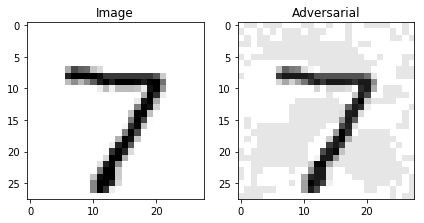

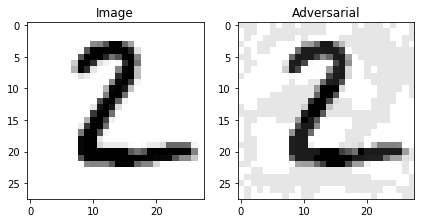

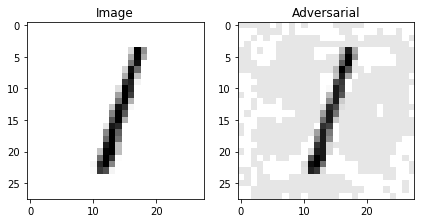

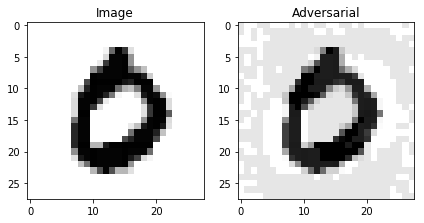

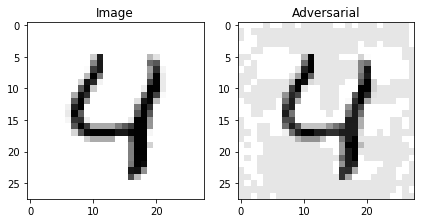

In [6]:
num_adversarials = 100
image_logReg, adver_logReg = model_logisticReg.generate_adversarial(
                                                model_logisticReg,
                                                test_dataset.test_data[0:num_adversarials],
                                                test_dataset.test_labels[0:num_adversarials].reshape(-1))

model_logisticReg.visualize_image_and_adversarial(image_array=image_logReg[0:5].detach().numpy(),
                                                 adversarial_array=adver_logReg[0:5].detach().numpy(),
                                                 results=None)

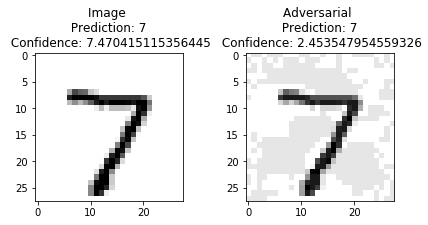

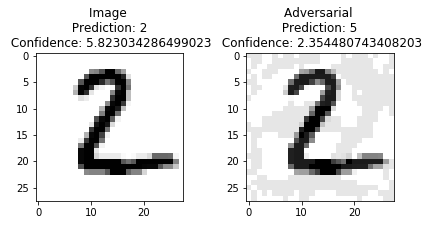

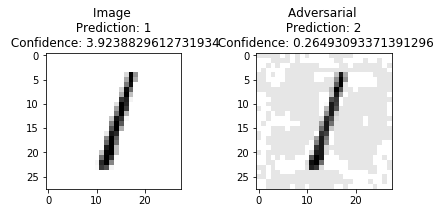

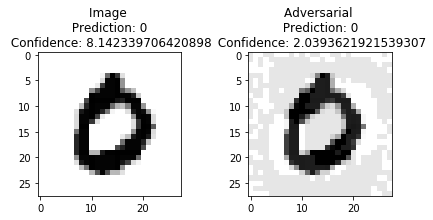

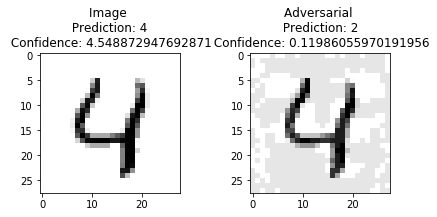

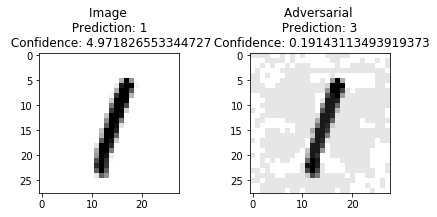

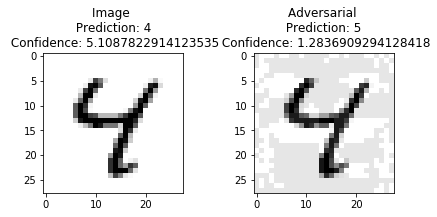

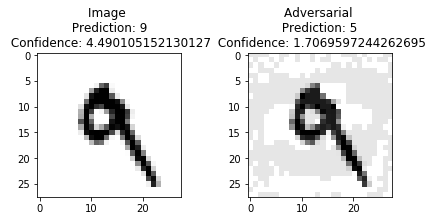

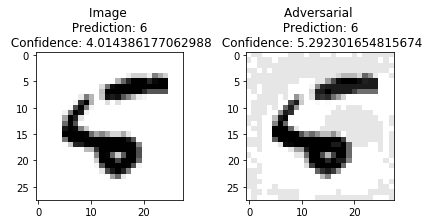

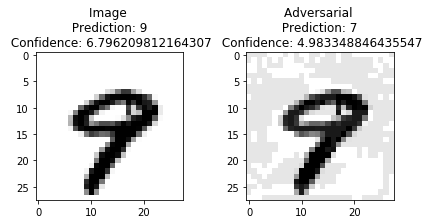

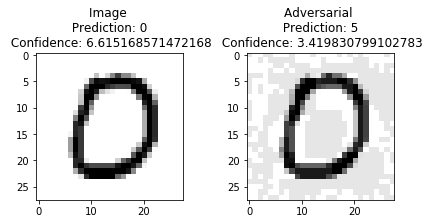

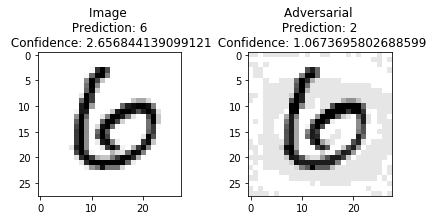

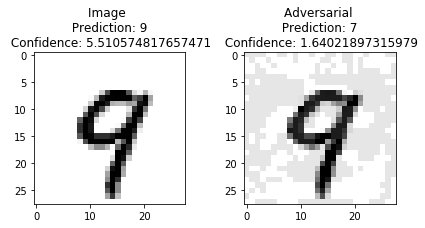

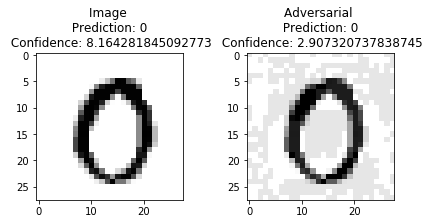

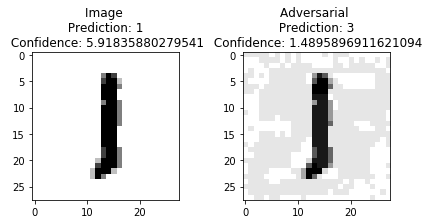

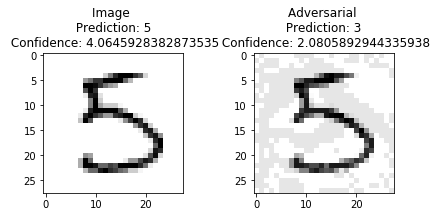

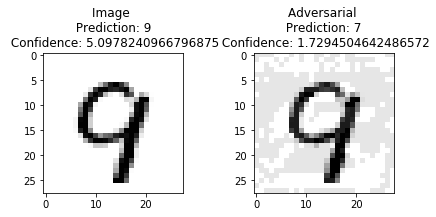

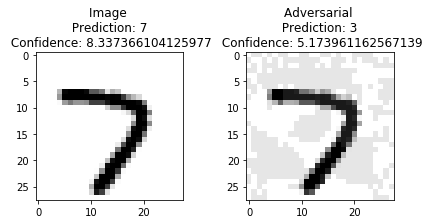

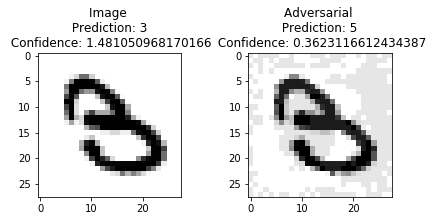

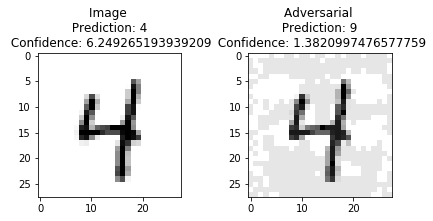

------------------------------------------------------------------
Accuracy on actual images: 93.0
Accuracy on adversarial images: 13.0


In [7]:
results = model_logisticReg.evaluate_adversarial_effect(
                                            model_logisticReg, image_logReg, 
                                            adver_logReg, 
                                            test_dataset.test_labels[0:num_adversarials].reshape(-1))
model_logisticReg.visualize_image_and_adversarial(results=results, num_visualize=20)
print ('------------------------------------------------------------------')
print ('Accuracy on actual images: {}'.format(results['acc_img']))
print ('Accuracy on adversarial images: {}'.format(results['acc_adv']))

In [8]:
model_SVM = LinearModel(input_dim, output_dim, algorithm_name='SVM')
model_SVM.fit_and_evaluate(model_SVM, train_dataset, test_dataset)

Epoch: 1. Training Loss: 1.1463563442230225. Test Accuracy: 85.51
Epoch: 2. Training Loss: 0.7432065010070801. Test Accuracy: 88.54
Epoch: 3. Training Loss: 0.8240160346031189. Test Accuracy: 89.46
Epoch: 4. Training Loss: 0.5738454461097717. Test Accuracy: 90.16
Epoch: 5. Training Loss: 0.5464866757392883. Test Accuracy: 90.41
Epoch: 6. Training Loss: 0.5804406404495239. Test Accuracy: 90.72
Epoch: 7. Training Loss: 0.5325770974159241. Test Accuracy: 90.81
Epoch: 8. Training Loss: 0.44195684790611267. Test Accuracy: 91.1
Epoch: 9. Training Loss: 0.4899072051048279. Test Accuracy: 91.06
Epoch: 10. Training Loss: 0.4252431094646454. Test Accuracy: 91.31


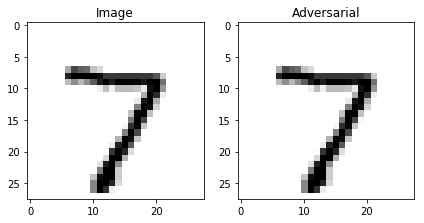

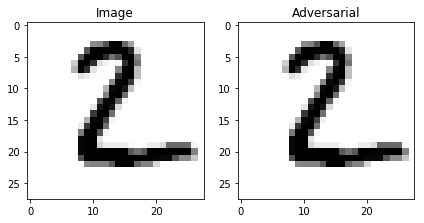

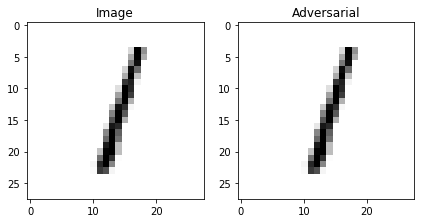

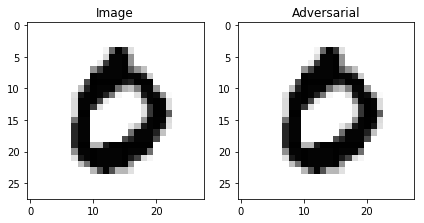

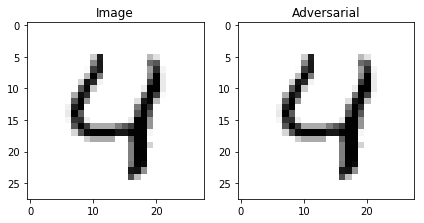

In [9]:
num_adversarials = 100
image_svm, adver_svm = model_SVM.generate_adversarial(
                                                model_SVM,
                                                test_dataset.test_data[0:num_adversarials],
                                                test_dataset.test_labels[0:num_adversarials].reshape(-1),
                                                epsilon=0.5)

model_SVM.visualize_image_and_adversarial(image_array=image_svm[0:5].detach().numpy(),
                                                 adversarial_array=adver_svm[0:5].detach().numpy(),
                                                 results=None)

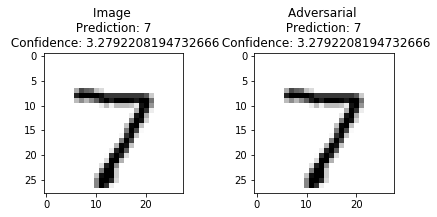

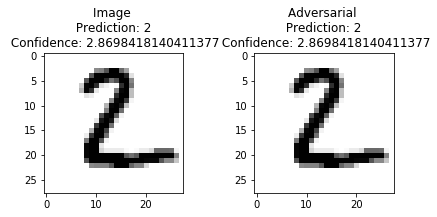

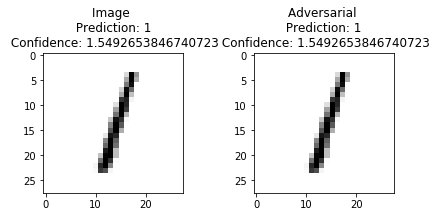

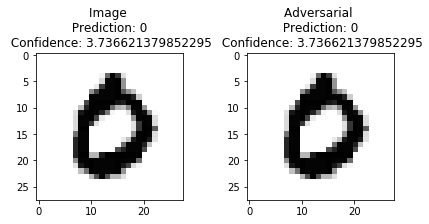

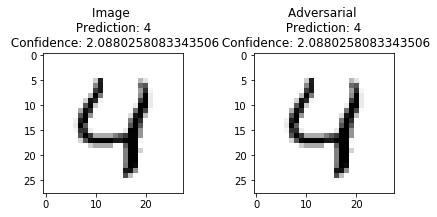

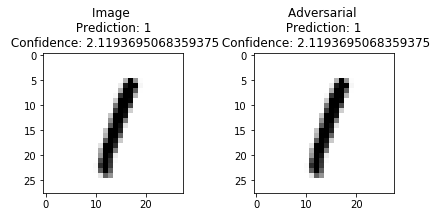

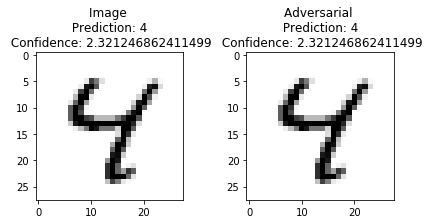

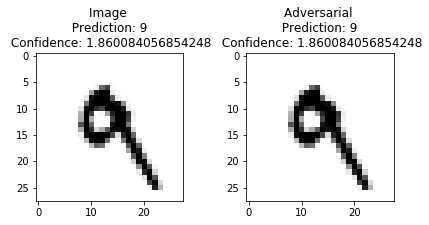

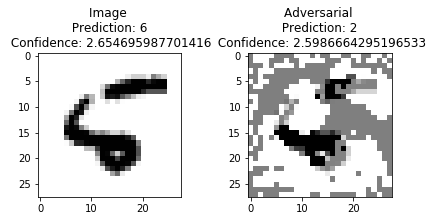

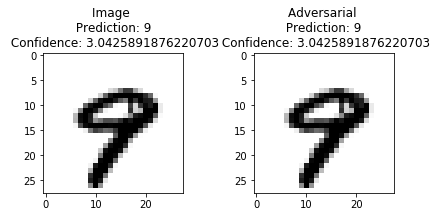

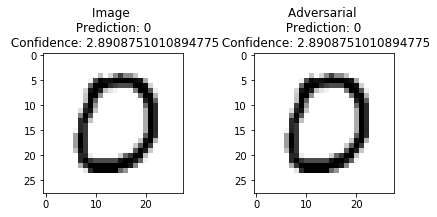

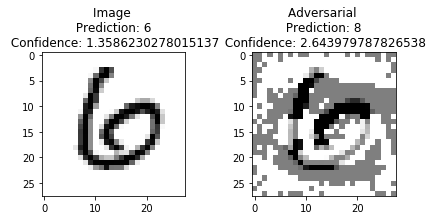

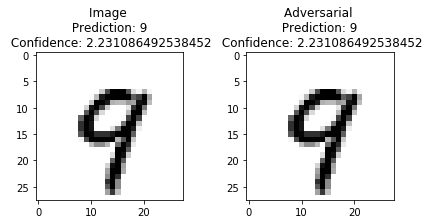

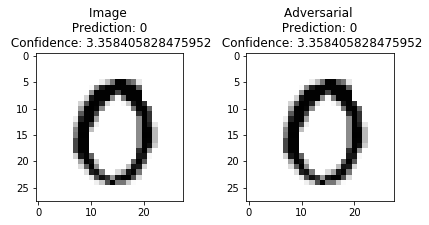

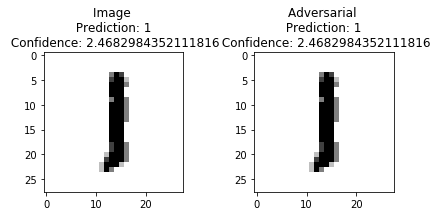

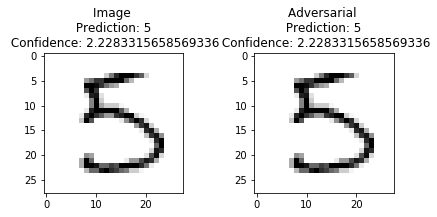

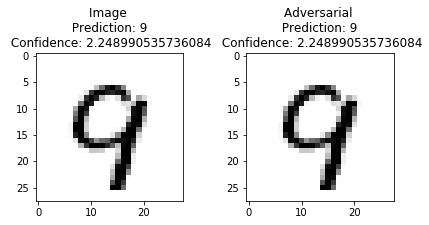

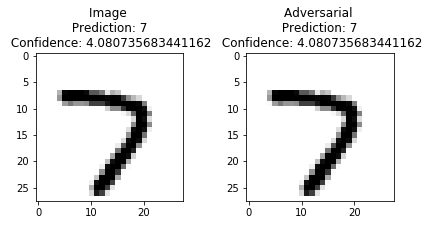

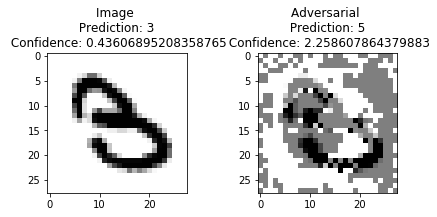

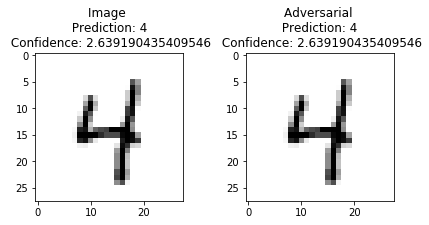

------------------------------------------------------------------
Accuracy on actual images: 94.0
Accuracy on adversarial images: 71.0


In [10]:
results = model_SVM.evaluate_adversarial_effect(
                                            model_SVM, image_svm, 
                                            adver_svm, 
                                            test_dataset.test_labels[0:num_adversarials].reshape(-1))
model_SVM.visualize_image_and_adversarial(results=results, num_visualize=20)
print ('------------------------------------------------------------------')
print ('Accuracy on actual images: {}'.format(results['acc_img']))
print ('Accuracy on adversarial images: {}'.format(results['acc_adv']))